# Group Seminar on Julia Pt. II
# Parallel Programming

- Julia's parallel architecture, like MPI, uses message passing between worker processes.
- Distributed Memory architecture $\rightarrow$ Each worker has its own memory.
- It is however more transparent and high level.

## 1. Add worker processes.

In [121]:
workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [7]:
addprocs();nworkers()

4

In [3]:
nprocs()

4

   ## 2. Running functions in parallel

In [122]:
r = remotecall(2, +, 1,1)

RemoteRef{Channel{Any}}(2,1,3500700)

In [126]:
fetch(r)

2

In [127]:
remotecall_fetch(2, +, 1,1)

2

### `remotecall` and `fetch` are rather "low level" and cumbersome.
### Julia offers convenient macros `@spawn`, `@spawnat`, `@fetch`

In [ ]:
@spawn svd(rand(10,10))

In [ ]:
fetch(ans)

In [ ]:
@fetch svd(rand(10,10))

### Transforming datasets in parallel with `pmap`.

In [16]:
matrices = [ rand(5,5) for i in 1:5 ];
pmap(svd, matrices)

5-element Array{Any,1}:
 (
5x5 Array{Float64,2}:
 -0.205853   0.269247   0.0264854  -0.248645   -0.906976 
 -0.632522   0.285297   0.400676    0.593299    0.0773038
 -0.312394   0.364526   0.26683    -0.739294    0.389585 
 -0.335568   0.326003  -0.872051    0.0572403   0.131783 
 -0.589359  -0.779073  -0.0841801  -0.190627   -0.0477111,

[2.3719547394705582,0.7957276578293622,0.6657334914845886,0.47035748293819835,0.18944348138829634],
5x5 Array{Float64,2}:
 -0.450931   0.433229   0.723943  -0.169013  -0.23731  
 -0.295611  -0.561904  -0.12015   -0.680117  -0.34624  
 -0.30736    0.374743  -0.563867   0.241121  -0.623709 
 -0.587689   0.23771   -0.342729  -0.21582    0.658844 
 -0.519065  -0.547392   0.161439   0.635734   0.0267221)                   
 (
5x5 Array{Float64,2}:
 -0.395626  -0.233087   0.792843   0.354645   -0.186488
 -0.403655   0.233286  -0.188295  -0.301932   -0.809952
 -0.474802   0.33344    0.244908  -0.596176    0.497971
 -0.493459  -0.753822  -0.401746  -0.0698338

In [15]:
for i = 1:nworkers()
    local matrices = [ rand(500,500) for j in 1:10 ];
    @time pmap(svd, matrices, pids=workers()[1:i]);
end

  3.885712 seconds (3.48 k allocations: 38.333 MB)
  2.040093 seconds (3.37 k allocations: 38.339 MB)
  1.693605 seconds (3.82 k allocations: 40.354 MB)
  1.282255 seconds (3.86 k allocations: 41.298 MB)


__Caveat:__ `pmap` only suitable for distributing large chunks of work.

In [21]:
@time pmap(x->x+1, collect(1:Int(1e5)));

  7.211108 seconds (25.30 M allocations: 1.477 GB, 4.23% gc time)


In [20]:
@time collect(1:Int(1e5)) + 1 ;

  0.000843 seconds (11 allocations: 1.526 MB)


### `@parallel` to the rescue!

__Scenario:__ Parallel calculations that are reduced (Matrix$\rightarrow$Vector, Vector$\rightarrow$Number)

In [9]:
@time randWalk = @parallel (+) for i = 1:Int(1e8)
    randn()
end

  0.150018 seconds (7.13 k allocations: 440.762 KB)


16439.59126606235

In [11]:
@time reduce(+, randn(Int(1e8)))

  0.666955 seconds (8 allocations: 762.940 MB, 0.44% gc time)


-20786.74550077975

In [1]:
s = 0.0
@time for i = 1:Int(1e8)
    s += randn()
end
s

  2.613190 seconds (200.00 M allocations: 2.980 GB, 3.25% gc time)


8532.439742472616

In [10]:
function randomWalk_serial(L::Int)
    s = 0.0
    for i = 1:L
        s += randn()
    end
    s
end
@time randomWalk_serial(Int(1e8))

  0.484700 seconds (2.62 k allocations: 129.583 KB)


2540.0213527396704

----

__What if we need the results of every run?__  
Naively one could concatinate the results ($=$reduce with `vcat`).

In [232]:
L = Int(1e5);

In [137]:
@time n = @parallel (vcat) for i in 1:L
    randn()
end;

  1.456015 seconds (4.85 k allocations: 2.829 MB)


__Abysmal runtime! __ Note the allocations.  
`vcat` allocates new memory __each__ iteration $\rightarrow$ dynamical resizing of arrays is not a good idea in performance critical code.

Alright, allocate the memory beforehand...

In [142]:
a = zeros(Int64, L)
@time rs = @parallel for i in 1:L
    a[i] = randn()
end;

  0.004370 seconds (4.45 k allocations: 329.217 KB)


Ok, that was fast, but did it do what we wanted?

In [19]:
println(maximum(a))

0


__No__, because `a[]` inside the parallel for-loop is a __local variable__ to each process.

__Needed:__ Data structure that is shared between processes.

### Shared Arrays

In [243]:
L = Int(1e9);

In [244]:
ShA = SharedArray(Float64, L, init= S->S[localindexes(S)] = 0);

In [235]:
ShA.pids

4-element Array{Int64,1}:
 2
 3
 4
 5

In [236]:
[@fetchfrom i localindexes(ShA) for i in workers()]

4-element Array{Any,1}:
 1:2500000       
 2500001:5000000 
 5000001:7500000 
 7500001:10000000

In [245]:
@time @parallel for i in 1:length(ShA)
    ShA[i] = randn()
end;

  0.003301 seconds (5.75 k allocations: 423.192 KB)


In [248]:
@everywhere function Randn(S::SharedArray)
    for i in localindexes(S)
        S[i] = randn()
    end
end
@time @sync begin 
    for p in ShA.pids
        @async remotecall(p, Randn, ShA)
    end
end;

  0.003890 seconds (1.59 k allocations: 134.914 KB)


In [218]:
ShA[1:10]

10-element Array{Float64,1}:
 -0.779417
 -1.12017 
  0.508566
 -1.49702 
  0.83291 
 -1.11377 
  3.09782 
 -1.45424 
 -0.386429
  1.61744 

In [249]:
@time randn(L);

 29.514472 seconds (103 allocations: 7.451 GB, 12.73% gc time)


In [161]:
using Gadfly

INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/Calculus.ji for module Calculus.
INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/DualNumbers.ji for module DualNumbers.
INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/Gadfly.ji for module Gadfly.
INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/Colors.ji for module Colors.
INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/FixedPointNumbers.ji for module FixedPointNumbers.
INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/lib/v0.4/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /Network/Servers/mac25.thp.uni-koeln.de/Volumes/RAID/skleinbo/.julia/

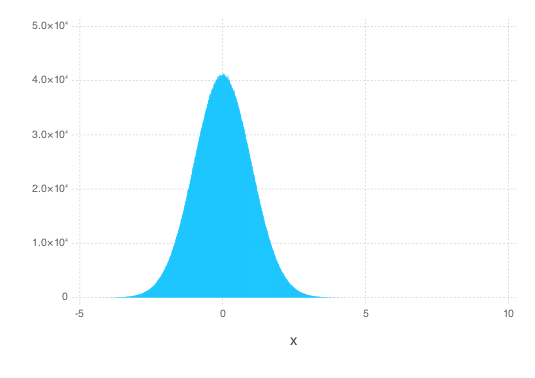

In [238]:
Gadfly.plot(x=ShA,Geom.histogram(bincount=1000))